## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

In [3]:
from my_classes import DataGenerator, AugmentedDataGenerator

In [4]:
# Load the data
h5f = h5py.File('data/data_cano_nearest_neighbor.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3011, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [5]:
from models import Squeeze_model

In [6]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [7]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*16
nb_epochs = 200
l_rate = 1e-4

In [8]:
data_gen = DataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
val_gen = DataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

In [9]:
# Build the model and train
model_input = Input(shape=(24, 24, 24, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)
model.compile(optimizer=optimizers.adam(lr=l_rate),# decay=decay_rate, beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')
              #target_tensors=[staging_area_callback.target_tensor],
              #fetches=staging_area_callback.extra_ops)

In [10]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-cano_original.h5"

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [11]:
history = model.fit_generator(generator=data_gen, validation_data=val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=10, 
                              workers=56, 
                              verbose=1, callbacks=callbacks_list)

Epoch 1/200
47/47 [==============================] - 12s 258ms/step - loss: 3.2807 - val_loss: 1.9082

Epoch 00001: val_loss improved from inf to 1.90818, saving model to ./weights/weights-cano_original.h5
Epoch 2/200
47/47 [==============================] - 5s 113ms/step - loss: 1.5308 - val_loss: 1.4288

Epoch 00002: val_loss improved from 1.90818 to 1.42879, saving model to ./weights/weights-cano_original.h5
Epoch 3/200
47/47 [==============================] - 5s 114ms/step - loss: 1.5068 - val_loss: 1.3852

Epoch 00003: val_loss improved from 1.42879 to 1.38523, saving model to ./weights/weights-cano_original.h5
Epoch 4/200
47/47 [==============================] - 5s 116ms/step - loss: 1.4992 - val_loss: 1.5656

Epoch 00004: val_loss did not improve from 1.38523
Epoch 5/200
47/47 [==============================] - 5s 115ms/step - loss: 1.5071 - val_loss: 1.7817

Epoch 00005: val_loss did not improve from 1.38523
Epoch 6/200
47/47 [==============================] - 5s 113ms/step - l

47/47 [==============================] - 5s 116ms/step - loss: 0.2758 - val_loss: 1.5098

Epoch 00052: val_loss did not improve from 1.31641
Epoch 53/200
47/47 [==============================] - 5s 113ms/step - loss: 0.2726 - val_loss: 1.7018

Epoch 00053: val_loss did not improve from 1.31641
Epoch 54/200
47/47 [==============================] - 5s 110ms/step - loss: 0.2991 - val_loss: 1.5028

Epoch 00054: val_loss did not improve from 1.31641
Epoch 55/200
47/47 [==============================] - 5s 115ms/step - loss: 0.3003 - val_loss: 1.6112

Epoch 00055: val_loss did not improve from 1.31641
Epoch 56/200
47/47 [==============================] - 6s 118ms/step - loss: 0.2664 - val_loss: 1.6046

Epoch 00056: val_loss did not improve from 1.31641
Epoch 57/200
47/47 [==============================] - 5s 109ms/step - loss: 0.3242 - val_loss: 1.6392

Epoch 00057: val_loss did not improve from 1.31641
Epoch 58/200
47/47 [==============================] - 6s 121ms/step - loss: 0.3789 - val_

47/47 [==============================] - 6s 118ms/step - loss: 0.1581 - val_loss: 1.4317

Epoch 00105: val_loss did not improve from 1.31641
Epoch 106/200
47/47 [==============================] - 6s 118ms/step - loss: 0.2005 - val_loss: 1.4855

Epoch 00106: val_loss did not improve from 1.31641
Epoch 107/200
47/47 [==============================] - 5s 114ms/step - loss: 0.1539 - val_loss: 1.6553

Epoch 00107: val_loss did not improve from 1.31641
Epoch 108/200
47/47 [==============================] - 5s 116ms/step - loss: 0.1553 - val_loss: 1.5966

Epoch 00108: val_loss did not improve from 1.31641
Epoch 109/200
47/47 [==============================] - 5s 115ms/step - loss: 0.2014 - val_loss: 1.5555

Epoch 00109: val_loss did not improve from 1.31641
Epoch 110/200
47/47 [==============================] - 5s 113ms/step - loss: 0.2012 - val_loss: 1.7306

Epoch 00110: val_loss did not improve from 1.31641
Epoch 111/200
47/47 [==============================] - 5s 115ms/step - loss: 0.1804 

47/47 [==============================] - 7s 153ms/step - loss: 0.2387 - val_loss: 1.6212

Epoch 00158: val_loss did not improve from 1.31641
Epoch 159/200
47/47 [==============================] - 7s 153ms/step - loss: 0.1863 - val_loss: 1.5693

Epoch 00159: val_loss did not improve from 1.31641
Epoch 160/200
47/47 [==============================] - 7s 149ms/step - loss: 0.1463 - val_loss: 1.5971

Epoch 00160: val_loss did not improve from 1.31641
Epoch 161/200
47/47 [==============================] - 7s 148ms/step - loss: 0.2091 - val_loss: 1.4828

Epoch 00161: val_loss did not improve from 1.31641
Epoch 162/200
47/47 [==============================] - 7s 153ms/step - loss: 0.1675 - val_loss: 1.4990

Epoch 00162: val_loss did not improve from 1.31641
Epoch 163/200
47/47 [==============================] - 8s 164ms/step - loss: 0.1894 - val_loss: 1.5423

Epoch 00163: val_loss did not improve from 1.31641
Epoch 164/200
47/47 [==============================] - 7s 149ms/step - loss: 0.1795 

In [18]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_cano_original.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

In [12]:
# Save the weights
model.load_weights(filepath)

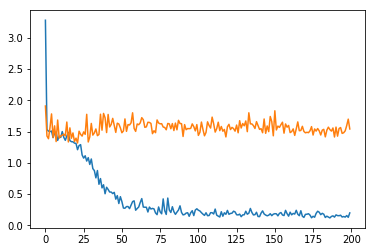

In [14]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [15]:
from sklearn.metrics import r2_score

In [16]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
train_r2 = r2_score(y_true=train_y[:2000], y_pred=model.predict(train_x[:2000]))
print("Train r2: ", train_r2)

Train r2:  0.424446551085


In [17]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
test_r2 = r2_score(y_true=test_y, y_pred=model.predict(test_x))
print("Test r2: ", test_r2)

Test r2:  0.301207122627
